In [1]:
import torch
from torchvision import datasets, transforms
import numpy as np
from matplotlib import pyplot as plt
from utils import plot_tsne
import numpy as np
import random
import argparse
from AutoEncoderDecoder import AutoEncoderMnist, AutoDecoderMnist, Classifier, trainEncoder, trainClassifier, evaluateClassifier 
from torch.utils.data import Dataset, DataLoader, random_split

In [2]:
def freeze_seeds(seed=0):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)

In [3]:
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5], std=[0.5])
    ])

In [4]:
freeze_seeds(0)

In [5]:
import os
current_dir = os.getcwd()
train_dataset = datasets.MNIST(root=current_dir, train=True, download=False, transform=transform)
test_dataset  = datasets.MNIST(root=current_dir, train=False, download=False, transform=transform)

In [6]:
def print_images(batch_images, num_to_print):
    fig, axes = plt.subplots(1, num_to_print, figsize=(12, 4))

    for i in range(num_to_print):
        image = batch_images[i].detach().numpy().transpose(1, 2, 0)

        # Plot the image
        axes[i].imshow(image, cmap='gray')
        axes[i].axis('off')

    plt.show()

Train AutoEncoder
Epoch [1/1], Train Loss: 0.0063, Validation Loss: 0.0030


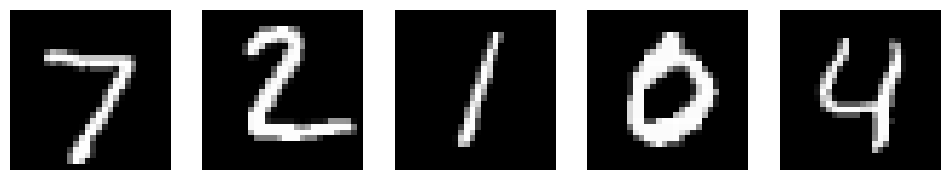

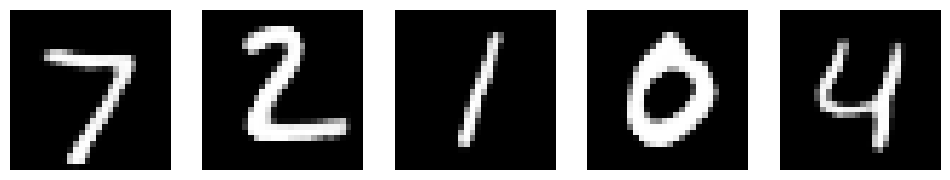

In [7]:
train_size = int(0.8 * len(train_dataset))
val_size   = len(train_dataset) - train_size

train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])

dl_train = DataLoader(train_dataset, batch_size=16, shuffle=True)
dl_test  = DataLoader(test_dataset, batch_size=16, shuffle=False)
dl_val   = DataLoader(val_dataset, batch_size=16, shuffle=False)

im_size = train_dataset[0][0].shape

encoder = AutoEncoderMnist(in_channels=im_size[0] ,latent_dim=128)
decoder = AutoDecoderMnist(latent_dim=128, out_channels=im_size[0])

epochs = 1
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
trainEncoder(encoder, decoder, epochs, dl_train, dl_val, device=device)

batch_images, _ = next(iter(dl_test))
batch_images    = batch_images.to(device)

print_images(batch_images, num_to_print=5)
encoded = encoder(batch_images)
decoded = decoder(encoded)  
print_images(decoded, num_to_print=5)

# t-SNE
#plot_tsne(encoder, dl_test ,device)

In [8]:
# Adding a classifier
print("Section 1.2.1.2")
encoder.eval() # Set encoder to evaluation mode to avoid updates during training

# Freeze the encoder parameters
for param in encoder.parameters():
    param.requires_grad = False

classifier = Classifier(latent_dim=128)
epochs = 1
trainClassifier(encoder, classifier, epochs, dl_train, dl_val, device)
evaluateClassifier(encoder, classifier, dl_test, device)

Section 1.2.1.2
Train Classifier
Epoch [1/1], Train Loss: 1.4815, Train Accuracy: 85.38%, Validation Loss: 0.9349, Validation Accuracy: 87.99%
Evaluate Classifier
Test Loss: 0.8351, Test Accuracy: 89.38%


In [9]:
print("Section 1.2.2")
from AutoEncoderDecoder import ClassifierModel_122, trainClassifier122, evaluateClassifier122

encoder_122    = AutoEncoderMnist(in_channels=im_size[0] ,latent_dim=128)
classifier_122 = Classifier(latent_dim=128)

model = ClassifierModel_122(encoder_122, classifier_122).to(device)

# Train the entire model (encoder + classifier) to minimize classification loss
trainClassifier122(model, epochs=1, dl_train=dl_train, dl_val=dl_val, device=device)
evaluateClassifier122(model, dl_test, device)
# t-SNE
#plot_tsne(encoder_122, dl_test ,device)

Section 1.2.2
Train Encoder + Classifier
Epoch [1/1], Train Loss: 0.1460, Train Accuracy: 95.55%, Validation Loss: 0.0685, Validation Accuracy: 97.92%
Test Loss: 0.0664, Test Accuracy: 97.89%


(0.06643298477546777, 97.89)

In [10]:
from AutoEncoderDecoder import ProjectionHead, trainEncoder123
print("Section 1.2.3")
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(20),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

train_dataset = datasets.MNIST(root=current_dir, train=True, download=False, transform=transform)
test_dataset  = datasets.MNIST(root=current_dir, train=False, download=False, transform=transform)

train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])

dl_train = DataLoader(train_dataset, batch_size=16, shuffle=True)
dl_test  = DataLoader(test_dataset, batch_size=16, shuffle=False)
dl_val   = DataLoader(val_dataset, batch_size=16, shuffle=False)

# Initialize encoder, projection head, and loss function
encoder = AutoEncoderMnist(in_channels=im_size[0] ,latent_dim=128)
projection_head = ProjectionHead(in_dim=128, out_dim=128).to(device)
encoder123 = torch.nn.Sequential(encoder, projection_head)

epochs = 3
trainEncoder123(encoder123, epochs, dl_train, device)

# Add a classifier
classifier123 = Classifier(latent_dim=128)
trainClassifier(encoder123, classifier123, epochs, dl_train, dl_val, device)
evaluateClassifier(encoder123, classifier123, dl_test, device)

Section 1.2.3
trainEncoder123
Epoch 1/3, Loss: inf
Epoch 2/3, Loss: inf
Epoch 3/3, Loss: inf
Train Classifier
Epoch [1/3], Train Loss: 2.0138, Train Accuracy: 49.60%, Validation Loss: 1.6105, Validation Accuracy: 53.20%
Epoch [2/3], Train Loss: 1.6314, Train Accuracy: 53.35%, Validation Loss: 1.7066, Validation Accuracy: 52.98%
Epoch [3/3], Train Loss: 1.5817, Train Accuracy: 54.47%, Validation Loss: 1.5441, Validation Accuracy: 55.10%
Evaluate Classifier
Test Loss: 1.5166, Test Accuracy: 55.31%
